# Метод распространения меток (LPA)

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. "Лекция 3: Выделение сообществ"
* Документация:
    * https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.label_propagation.label_propagation_communities.html
    * https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_numpy_array.html
    * https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.density.html
    * https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html
    * https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.partition_quality.html

## Вопросы для совместного обсуждения

1\. Обсудите принцип работы LPA и реализацию этого алгоритма в `networkx.`

## Задачи для самостоятельного решения

In [137]:
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
import random
from collections import Counter, defaultdict
import numpy as np
import pandas as pd

<p class="task" id="1"></p>

1\. Загрузите граф карате-клуба и выделите в нем сообщества с помощью реализации алгоритма распространения меток из `networkx`.
Визуализируйте полученный результат. Для визуализации выберите несколько цветов (в соответствии с количеством выделенных сообществ) и раскрасьте узлы и связи в рамках одного сообщества этими цветами. Связи между узлами, состоящими в разных сообществах, отрисуйте черным цветом.

- [ ] Проверено на семинаре

In [138]:
def vis(G, nodes_hist, algorithm):      
    nrows, ncols = int(np.ceil(len(nodes_hist) / 5)), min(5, len(nodes_hist))
    fig, axes = plt.subplots(nrows, ncols, figsize=(nrows*5, ncols*5))
    if not isinstance(axes, np.ndarray):
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, ax in enumerate(axes[:len(nodes_hist)]):
        cmap = plt.get_cmap('flag', len(set(nodes_hist[i])))
        node_colors = [cmap(nodes_hist[i][node]) for node in G.nodes()]
        edge_colors = [cmap(nodes_hist[i][u]) if nodes_hist[i][u] == nodes_hist[i][v] 
                    else 'black' for u, v in G.edges()]
        pos = nx.spring_layout(G, seed=0)
        nx.draw(G, pos, ax=ax, with_labels=True, 
                node_color=node_colors, edge_color=edge_colors, node_size=300, 
                font_color='white', font_size=8, font_weight='bold')
        ax.set_title(f'{algorithm} итерация {i+1}') if isinstance(axes, np.ndarray) else ax.set_title(f'{algorithm}')
        ax.axis('off')
        
    for ax in axes[len(nodes_hist):]:
        ax.axis('off')

    plt.show()

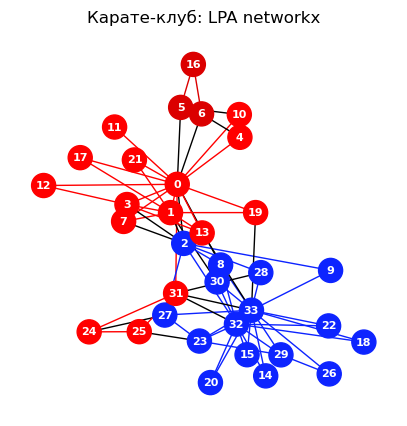

In [139]:
G = nx.karate_club_graph()
comms = nx_comm.label_propagation_communities(G)
nodes_labels = [{node: i for i, label in enumerate(comms) for node in label}]

vis(G, nodes_labels, 'Карате-клуб: LPA networkx')

<p class="task" id="2"></p>

2\. Реализуйте синхронный алгоритм распространения меток. В синхронном варианте алгоритма для выбора новой метки узла используются метки соседей с предыдущей итерации. Если среди меток соседей есть несколько вариантов с одинаковой максимальной частотой, то метка выбирается случайным образом. Алгоритм прекращает работу, когда на очередной итерации не была изменена метка ни одного узла. Визуализируйте пошаговую динамику распространения меток и итоговое разбиение сети аналогично предыдущей задаче.

- [ ] Проверено на семинаре

In [ ]:
def synch_lpa(G, seed=0):
    nodes_hist = []
    random.seed(seed)
    old_labels = {node: node for node in G}
    new_labels = {}
    while True:
        for node in G:
            counter = Counter(old_labels[n] for n in G.neighbors(node))
            most_common = [value for value, count in counter.items()
                           if count == max(counter.values())]
            new_labels[node] = random.choice(most_common)
        mapping = {l: i for i, l in enumerate(sorted(set(new_labels.values())))}
        nodes_labels = {n: mapping[l] for n, l in new_labels.items()}
        if new_labels == old_labels or nodes_labels in nodes_hist:
            break
        nodes_hist.append(nodes_labels.copy())
        old_labels = new_labels.copy()
    return nodes_hist

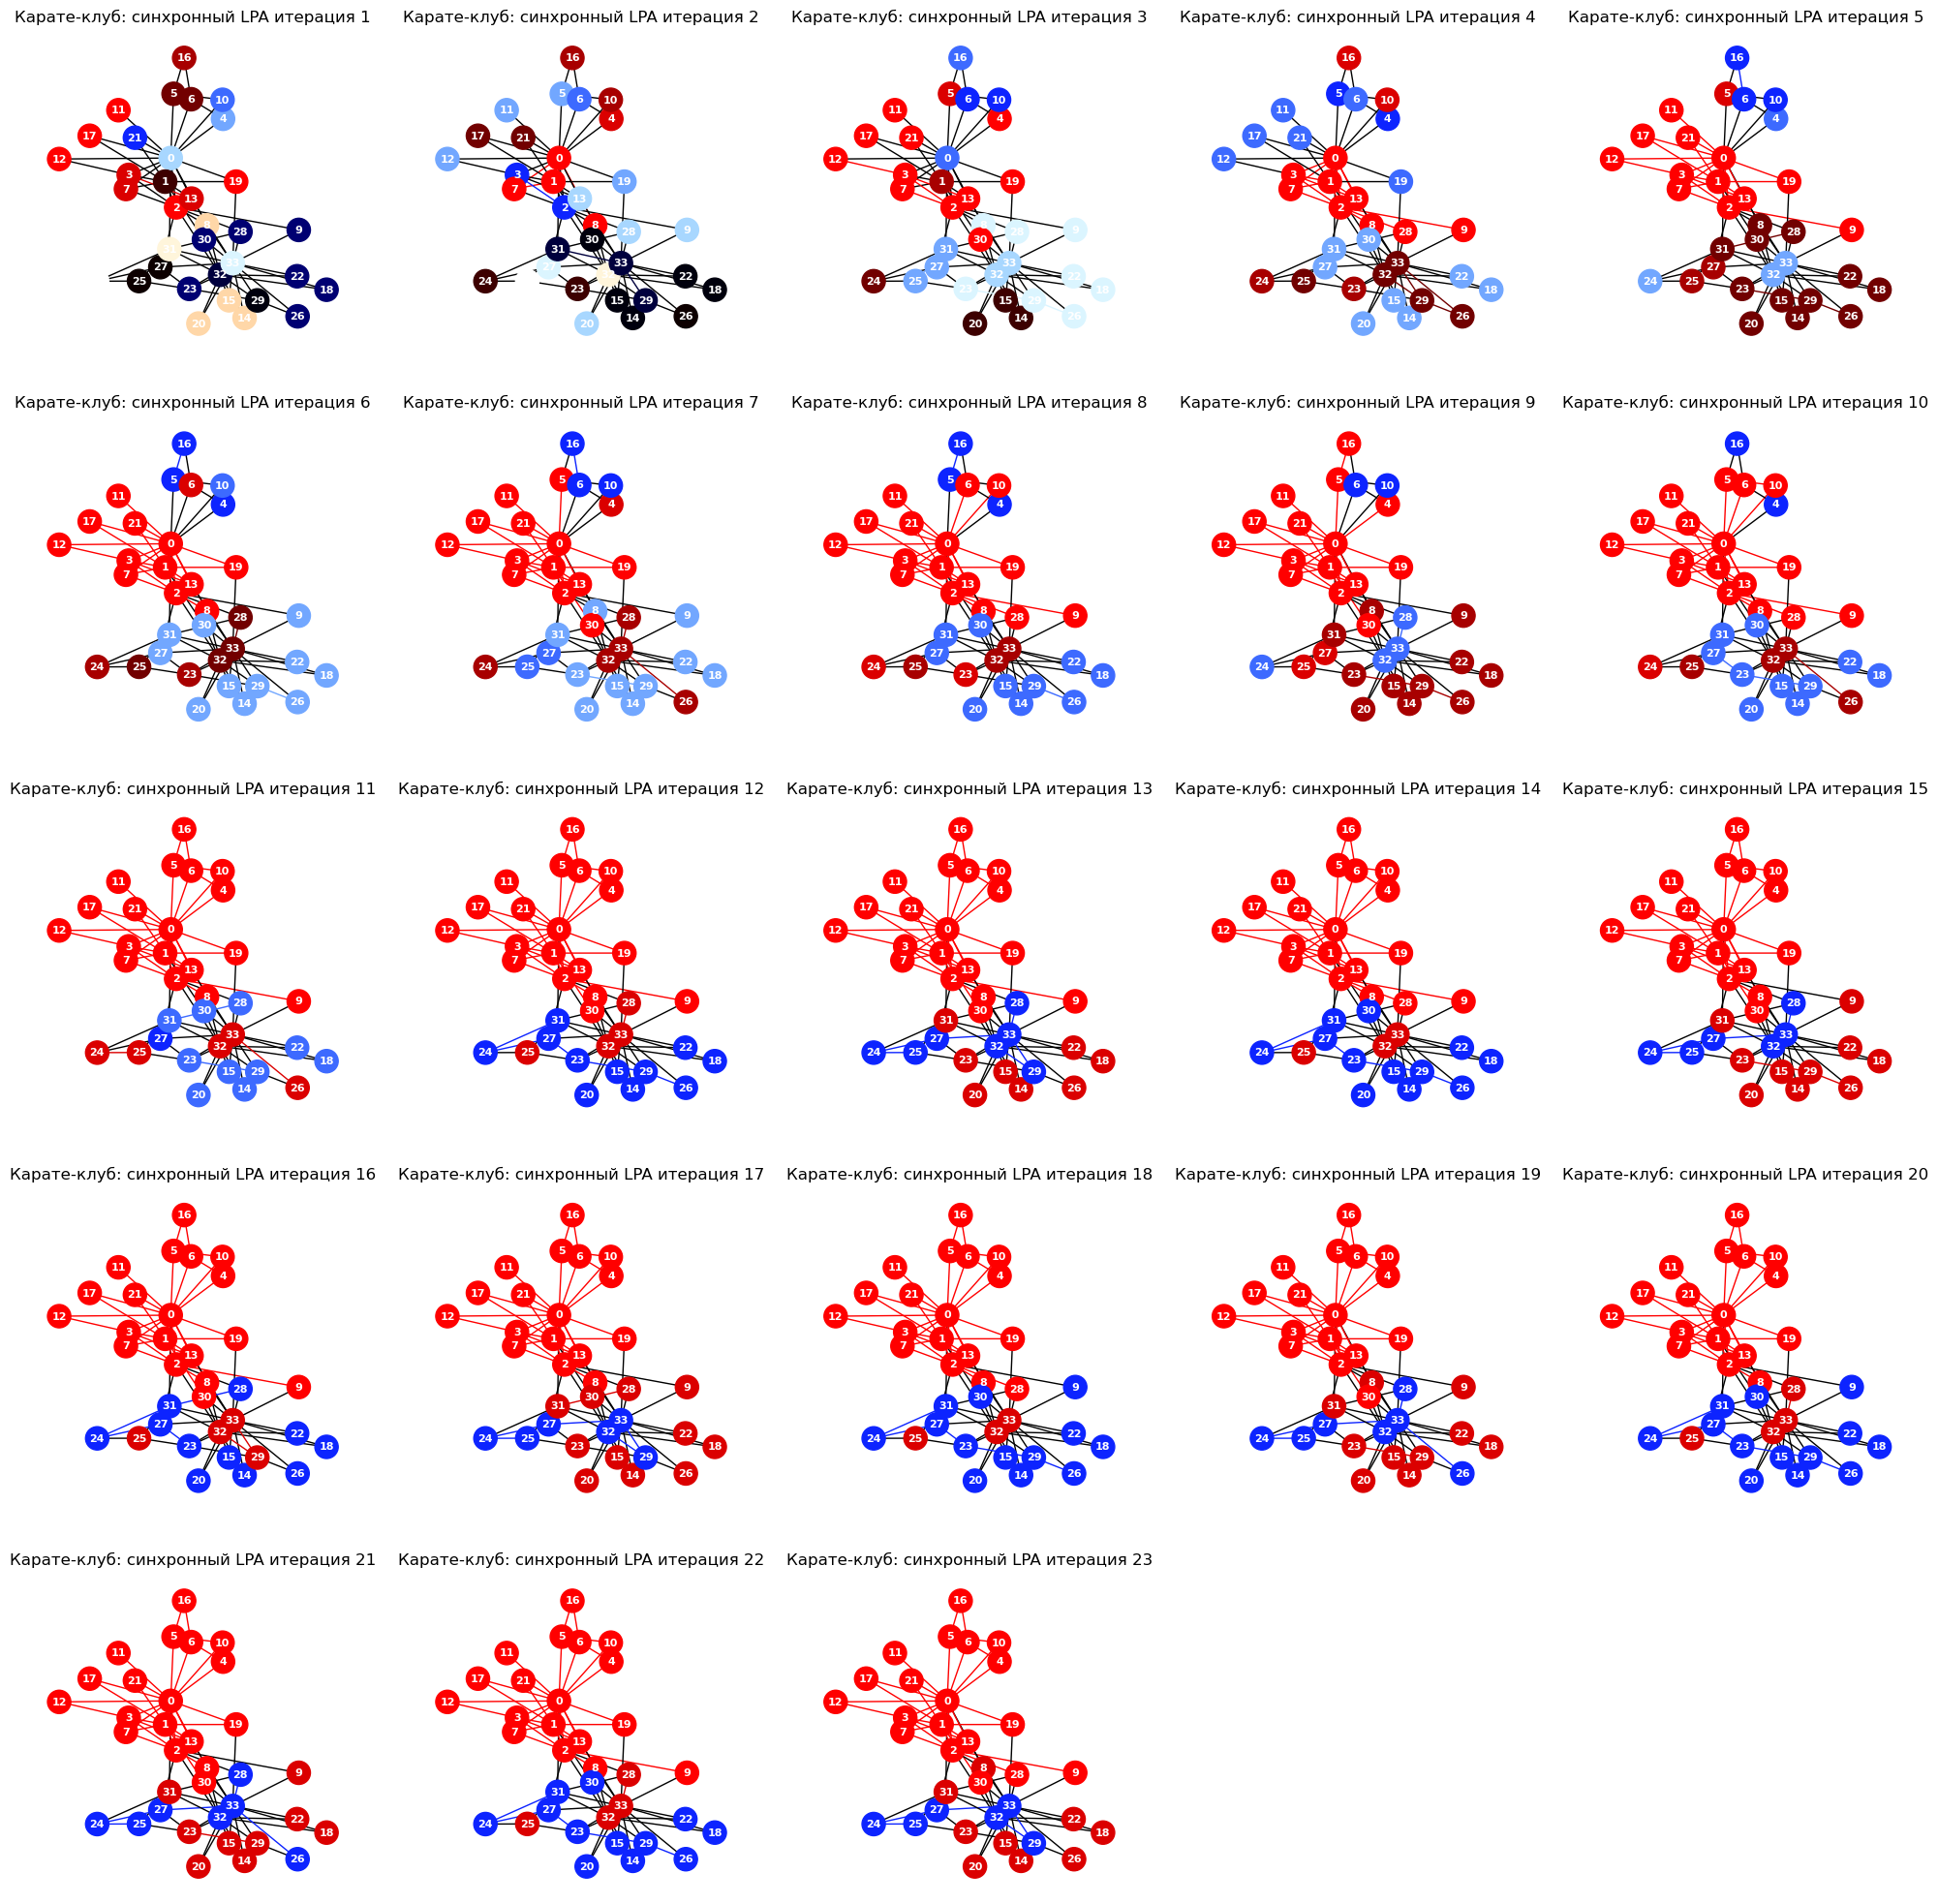

In [141]:
G = nx.karate_club_graph()
nodes_hist = synch_lpa(G)
vis(G, nodes_hist, 'Карате-клуб: синхронный LPA')

<p class="task" id="3"></p>

3\. Реализуйте асинхронный алгоритм распространения меток. В асинхронном варианте алгоритма для выбора новой метки узла используются в том числе метки соседей с текущей итерации алгоритма. Визуализируйте пошаговую динамику распространения меток и итоговое разбиение сети аналогично предыдущей задаче.

- [ ] Проверено на семинаре

In [142]:
def asynch_lpa(G, seed=0):
    random.seed(seed)
    nodes_hist = []
    labels = {node: node for node in G}
    while True:
        changed = False
        for node in G:
            old_label = labels[node]
            counter = Counter(labels[n] for n in G.neighbors(node))
            most_common = [value for value, count in counter.items()
                           if count == max(counter.values())]
            labels[node] = random.choice(most_common)
            if labels[node] != old_label:
                changed = True
        if not changed:
            break
    mapping = {l: i for i, l in enumerate(set(labels.values()))}
    nodes_labels = {n: mapping[l] for n, l in labels.items()}
    nodes_hist.append(nodes_labels.copy())
    return nodes_hist

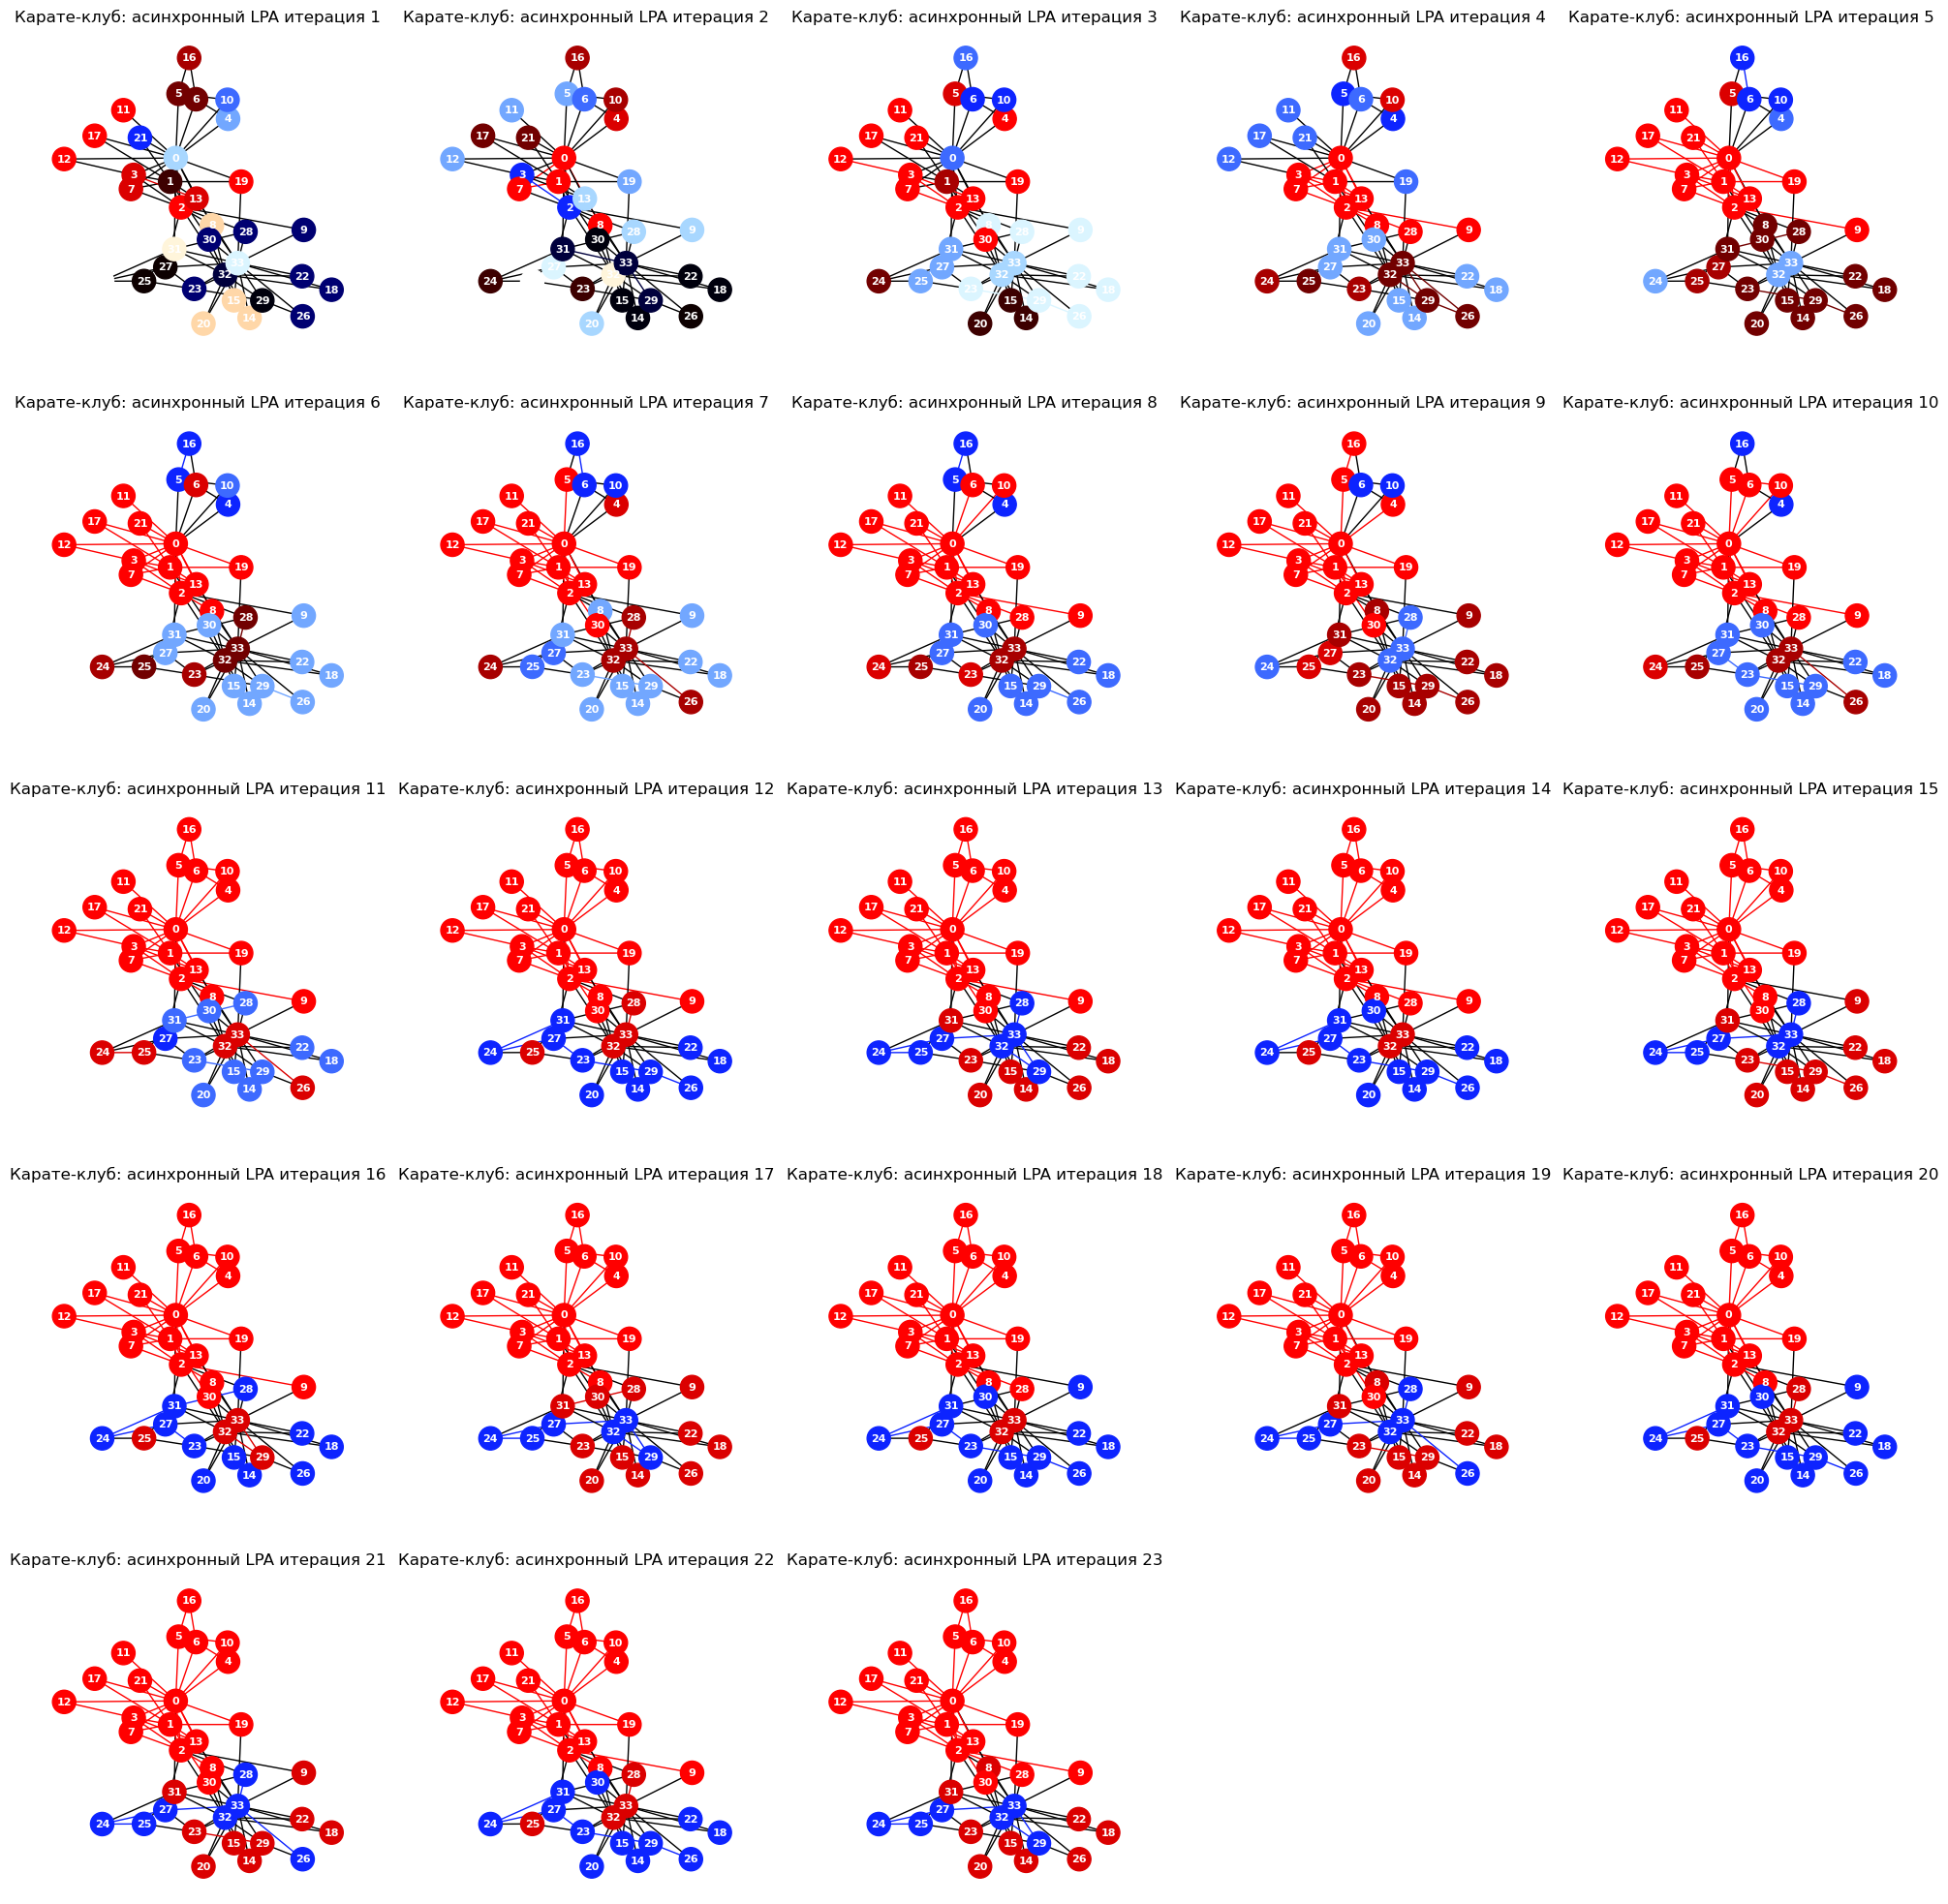

In [143]:
G = nx.karate_club_graph()
nodes_labels = asynch_lpa(G)

vis(G, nodes_hist, 'Карате-клуб: асинхронный LPA')

<p class="task" id="4"></p>

4\. Используя собственную реализацию LPA, разбейте граф карате-клуба на сообщества `N=10` раз. Создайте двумерный массив `freqs` размера `MxM` (`M` - количество узлов в графе), где `freqs[i, j]` показывает, как часто узлы `i` и `j` оказывались в одном сообществе.

Создайте граф, в котором между узлами `i` и `j` существует связь только тогда, когда `freqs[i, j] >= 8`. Получите компоненты связности данного графа. Интерпретируя данные компоненты связности как сообщества в исходном графе, визуализируйте полученное разбиение карате-клуба (оригинального графа) аналогично предыдущим заданиям.


- [ ] Проверено на семинаре

In [144]:
def multiple_lpa(G, threshold=8, seeds=10):
    freqs = np.zeros((len(G), len(G)))
    for seed in range(0, seeds):
        nodes_labels = asynch_lpa(G, seed=seed)[-1]
        for node, label in nodes_labels.items():
            for n, l in nodes_labels.items():
                if l == label:
                    freqs[node][n] += 1

    G_filtered = G.copy()
    for u, v in G.edges():
        if freqs[u][v] < threshold:
            G_filtered.remove_edge(u, v)

    comms = nx.connected_components(G_filtered)
    return [{node: i for i, label in enumerate(comms) for node in label}]

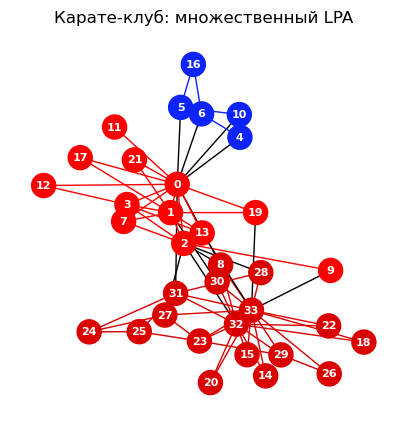

In [145]:
G = nx.karate_club_graph()
nodes_labels = multiple_lpa(G)
vis(G, nodes_labels, 'Карате-клуб: множественный LPA')

<p class="task" id="5"></p>

5\. Оформите результаты работы алгоритмов в виде таблицы

| Алгоритм                      | Средняя плотность сообществ | Модулярность | Покрытие | Эффективность |
|-------------------------------|-----------------------------|--------------|----------|----------|
| Синхронный LPA             |                             |              |          |          |
| Асинхронный LPA                     |                             |              |          |          |
| Множественный LPA                     |                             |              |          |          |

Для представления данных в табличном виде используйте `pandas`.  Все расчеты метрик при решении этой задачи выполните повторно.

- [ ] Проверено на семинаре

In [146]:
def compute_values(G, nodes_labels):
    comms = defaultdict(set)
    for node, comm in nodes_labels.items():
        comms[comm].add(node)

    dens = np.mean([nx.density(G.subgraph(comm)) for comm in comms.values()])
    mod = nx_comm.modularity(G, communities=[*comms.values()])
    cov, perf = nx_comm.partition_quality(G, partition=[*comms.values()])
    return dens, mod, cov, perf

In [147]:
G = nx.karate_club_graph()
rows = []

algorithms = [synch_lpa, asynch_lpa, multiple_lpa]
for a in algorithms:
    nodes_labels = a(G)[-1]
    rows.append(compute_values(G, nodes_labels))

results = pd.DataFrame(rows, ['Синхронный LPA', 'Асинхронный LPA', 'Множественный LPA'],
                        columns=['Средняя плотность сообществ', 'Модулярность', 'Покрытие', 'Эффективность']).round(4)
results.index.name = 'Алгоритм'
results 

,Средняя плотность сообществ,Модулярность,Покрытие,Эффективность
Алгоритм,,,,
Синхронный LPA,0.2035,0.1470,0.5385,0.6150
Асинхронный LPA,0.4156,0.4345,0.8205,0.7005
Множественный LPA,0.4045,0.4321,0.8205,0.7112
